In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import colors

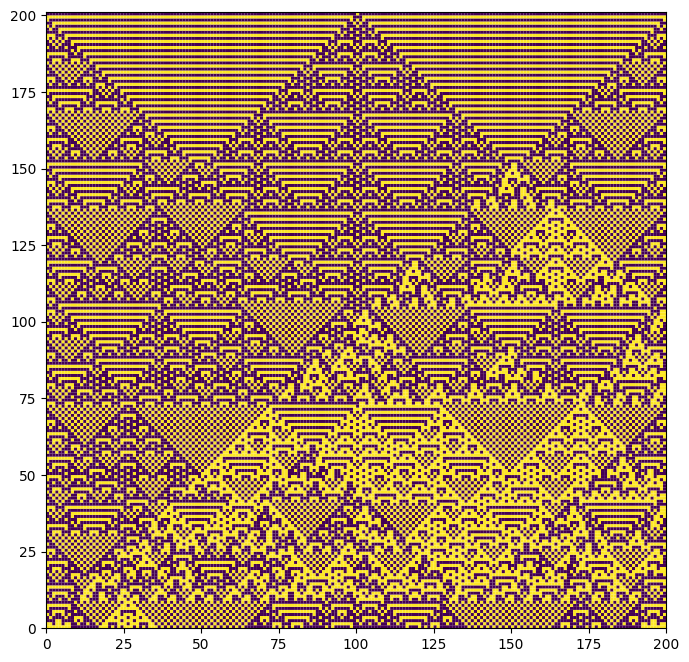

In [188]:
def get_rule_set_ECA(rule_n, patch_len, base=2):
    rule_variations_n = base**patch_len
    rule_len = base**rule_variations_n
    if rule_n > rule_len:
        raise ValueError(f"{rule_n} can not be larger than {rule_len}")

    rule = np.base_repr(rule_n, base=base).zfill(rule_variations_n)
    rule = np.array(list(rule), np.str_)

    return rule


# In this case, the "input" for the rule set is not really a patch (although it
# could be), but rather the summatory of the patch, so it is easier to compute
# thus the array this function returns can be used to retrieve the state based
# on the summatory.
# Ej 1:
# Function input:
#   Rule 53, patch len = 5, base 2
# if the patch has 5 digits, and base 2, the max summatory is 5, thus I need
# to return an array of 6 (zero is included)
# Rule set --> 1 1 0 1 0 1
# the rule set will be used rule_set[x], where x is the summatory of the patch
# and it will return the state
#
# Ej 2:
# Function input:
#   Rule 53, patch len = 3, base 3
# Max summatory is 6, thus I need to return an array of 7 (zero included)
# in this case 53 must be translated to base 3, and pad with zeros
# --> 0 0 0 1 2 2 2
def get_rule_set_TCA(rule_n, patch_len, states_n=2):
    # our status go from 0 to n... zero counts too

    # rule_len is always the max number of the summatory. Since zero does not
    # add up, we have to remove 1
    rule_len = patch_len * (states_n - 1) + 1

    # Now we have to restablish the zero to calculate the variations
    rule_variations = states_n**rule_len
    if rule_n > rule_variations - 1:
        raise ValueError(f"{rule_n} can not be larger than {rule_variations-1}")

    rule = np.base_repr(rule_n, base=states_n).zfill(rule_len)
    print(states_n, rule_variations, rule_len)
    print(rule)
    rule = np.array(list(rule), np.str_)

    return rule


def print_grid(grid):
    #cmap = colors.ListedColormap(["Blue", "red", "green", "black", "white", "yellow"])

    # data = np.random.randint(0, 2, size=(150, 150))
    plt.figure(figsize=(8, 8))
    plt.pcolor(grid, edgecolors="k", linewidths=0)
    plt.show()


class CArule2D:
    def __init__(self, rule_code, patch_len=3, states_n=2, type="elementary"):
        self.rule_code = rule_code
        self.states_n = states_n
        self.patch_len = patch_len

        self.type = type

        self.pad_for_grid = ["0"] * int(patch_len / 2)

        if type == "elementary":
            self.rule_set = get_rule_set_ECA(rule_code, patch_len, states_n)

        if type == "totalistic":
            self.rule_set = get_rule_set_TCA(rule_code, patch_len, states_n)

    def get_state(self, patch):

        if not isinstance(patch, np.ndarray):
            raise ValueError("Patch must be ndarray")
            
        if self.type == "elementary":
            return self.get_state_ECA(patch)

        if self.type == "totalistic":
            return self.get_state_TCA(patch)

    def get_state_TCA(self, patch):

        sum = patch.astype(int).sum()

        #lala = len(self.rule_set) - sum -1
        #print(sum, lala, self.rule_set[lala])
        return self.rule_set[::-1][sum]

    def get_state_ECA(self, patch):

        # tratar de resolver esto sin tener que apsarlo a string
        # idealmente debería ser todo con ndarray, y el get_state aceptar un 
        # string (que ahora sería tonto, ya que lo acepta, lo pondría como array y aca lo vuelve a poner como string...)
        patch = "".join(str(x) for x in patch)

        if len(patch) != self.patch_len:
            raise ValueError(
                f"Patch must have width {self.patch_len}, got {len(patch)}"
            )


        idx = int(patch, base=self.states_n)
        idx = len(self.rule_set) - idx - 1

        return self.rule_set[idx]

       


class CelluarAutomaton2D:
    def __init__(self, rule, init_row):
        self.rule = rule
        self.current_row = init_row

    def run_steps(self, n_steps, remove_previous_step=True):

        pad_len = len(self.rule.pad_for_grid)
        lala_len = len(self.current_row)

        grid_w = lala_len + pad_len * 2
        grid_h = n_steps + 1

        grid = np.zeros((grid_h, grid_w), dtype=int)
        grid = grid.astype(str)

        grid[0] = np.concatenate(
            (self.rule.pad_for_grid, self.current_row, self.rule.pad_for_grid)
        )

        for step in range(1, n_steps + 1):

            for moving_idx in range(lala_len):
                patch = grid[step - 1][moving_idx : moving_idx + self.rule.patch_len]
                grid[step][moving_idx + pad_len] = self.rule.get_state(patch)

        return grid[:, pad_len:][:, :-pad_len]


rule_base = 2
patch_len = 3
rule = 105
rule = CArule2D(rule, patch_len=patch_len, states_n=rule_base, type="elementary")
# rule.get_state_from_patch("100")

init = np.array(["0"] * 200)
init[int(len(init) / 2)] = 1

# init = np.random.randint(rule_base, size=200)

c = CelluarAutomaton2D(rule, init_row=init)

grid = c.run_steps(200)

grid = grid.astype(float)
grid = np.flipud(grid)
# c.process_steps(1)

# get_array_from_rule(154,3)

print_grid(grid)


In [142]:
rule.rule_set

array(['0', '0', '0', '0', '1', '0', '0', '0'], dtype='<U1')

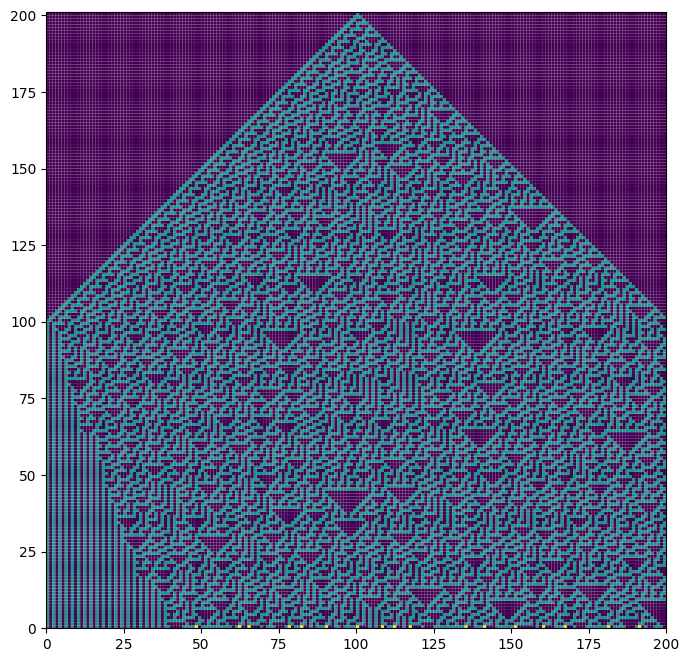

In [170]:
def status_func(rules, patch):

    # patch_ = np.array(
    #     [
    #         rules[0].get_state(patch),
    #         rules[1].get_state(patch),
    #         rules[2].get_state(patch),
    #     ]
    # )
    # # res = "0"
    # # if rules[0].get_state(patch) == rules[1].get_state(patch) and rules[0].get_state(patch) =="1":
    # #     res = "1"
    # return rules[3].get_state(patch_)

    #return rules[2].get_state(patch)

    patch[patch == "2"] = "1"

    res1 = rules[0].get_state(patch)
    res2 = rules[1].get_state(patch)

    if res1 == "0":
        return res2
    else:
        if res2 == "1":
            return "2"
        return "0"


class CollabCelluarAutomaton2D:
    def __init__(self, rules, init_row, status_func):
        self.rules = rules
        self.current_row = init_row

        self.status_func = status_func

        # Calculating the pad len
        # add validations que las reglas sean consistentes
        # y el pad len sea mas elegante
        # = int(rules[0].patch_len / 2)
        self.row_len = len(init_row)

    def run_steps(self, n_steps, remove_previous_step=True):

        pad_len = int(self.rules[0].patch_len / 2)
        grid_w = self.row_len + pad_len * 2
        grid_h = n_steps + 1

        grid = np.zeros((grid_h, grid_w), dtype=int)
        grid = grid.astype(str)

        pad = pad_len * ["0"]
        grid[0] = np.concatenate((pad, self.current_row, pad))

        for step in range(1, n_steps + 1):

            for moving_idx in range(self.row_len):
                patch = grid[step - 1][
                    moving_idx : moving_idx + self.rules[0].patch_len
                ]
                grid[step][moving_idx + pad_len] = self.status_func(self.rules, patch)

        return grid[:, pad_len:][:, :-pad_len]


rule_base = 2
patch_len = 3
rule = 30
rule1 = CArule2D(rule_code=8, patch_len=3, states_n=2, type="elementary")
rule2 = CArule2D(rule_code=30, patch_len=3, states_n=2, type="elementary")
rule3 = CArule2D(rule_code=30, patch_len=3, states_n=2, type="elementary")
rule4 = CArule2D(rule_code=14, patch_len=3, states_n=2, type="elementary")

rules = [rule1, rule2, rule3, rule4]
# rule.get_state_from_patch("100")

init = np.array(["0"] * 200)
init[int(len(init) / 2)] = 1

# init = np.random.randint(rule_base, size=200)

c = CollabCelluarAutomaton2D(rules, init_row=init, status_func=status_func)

grid = c.run_steps(200)

grid = grid.astype(float)
grid = np.flipud(grid)
# c.process_steps(1)

# get_array_from_rule(154,3)

print_grid(grid)


In [307]:
import numpy as np

# def get_rule_set_TCA(rule_n, patch_len, states_n=2):
#     # our status go from 0 to n... zero counts too

#     # rule_len is always the max number of the summatory. Since zero does not
#     # add up, we have to remove 1
#     rule_len = patch_len * (states_n - 1) + 1

#     # Now we have to restablish the zero to calculate the variations 
#     rule_variations = states_n** rule_len
#     if rule_n > rule_variations-1:
#         raise ValueError(f"{rule_n} can not be larger than {rule_variations-1}")


#     rule = np.base_repr(rule_n, base=states_n).zfill(rule_len)
#     print(states_n, rule_variations, rule_len)
#     print(rule)
#     rule = np.array(list(rule), np.str_)

#     return rule


rule_base = 2
patch_len = 5
rule = 53
rule = CArule2D(rule, patch_len=patch_len, states_n=rule_base, type="totalistic")

a = np.array([1,1,1,1,1])
rule.get_state(a)

# 0 -> 1
# 1 -> 0
# 2 -> 1
# 3 -> 0
# 4 -> 1
# 5 -> 1

2 64 6
110101


'1'

In [297]:
a = np.array([0,0,0,0,1], str)
a = a.astype(int).sum()
print(a)
rule.rule_set[::-1][a]

1


'0'

In [296]:
rule.rule_set[::-1][1]

'0'

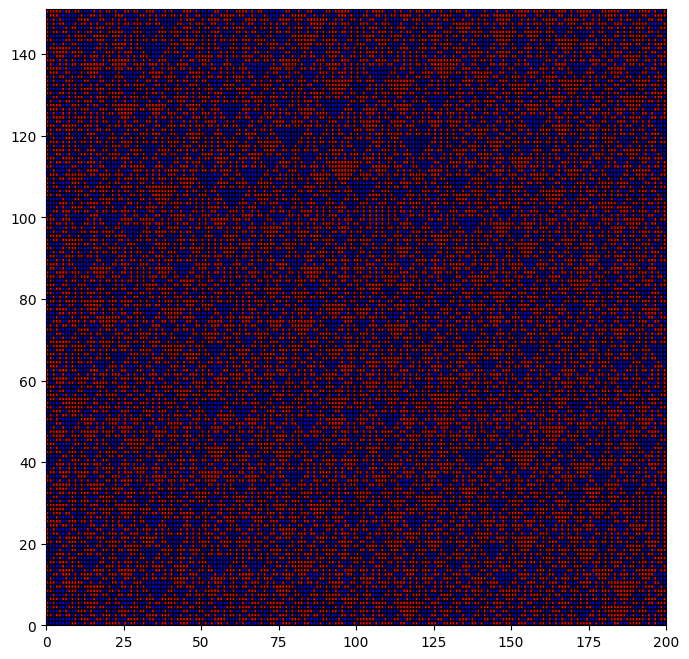

In [427]:
np.random.randint(2, size=10)

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [210]:
a = np.array([2,3,4,5])

# ''.join(str(x) for x in a)
a[::-1]

array([5, 4, 3, 2])

In [95]:
a = np.array(["1"] * 4)
a[1] = 2
a.astype(int).sum()


5

In [267]:
a = np.empty((2,3))
b = np.array([1,  2,  3])
a

array([[-2.00000000e+000,  1.28822985e-231,  1.48219694e-323],
       [ 0.00000000e+000,  0.00000000e+000,  4.17201348e-309]])

In [320]:
a = np.array([1,  2,  3])
b = np.array(([4, 4,4,4,4,4,4],[5, 5,5,5,5,5,5]))

b[0][2:2+3] = a
a[1] = 999
b

array([[4, 4, 1, 2, 3, 4, 4],
       [5, 5, 5, 5, 5, 5, 5]])

In [335]:
a = np.array([1,  2,  3,4,5,6,7])
pad = 2
le = 3

for n in range(3):
  print(a[n:n+le])

[1 2 3]
[2 3 4]
[3 4 5]


In [61]:
a = "111111"
a.zfill(5)

'111111'